# Goal

To predict the chemical species by matching deconvoluted PCA component spectra  against a reference library

# Approach

A correlation coefficient matrix will be creared by comparing the component spectra with each references. Pearson, Kendall-Tau and Spearmans correlation are available in pandas will be used. These coefficeints alone or in combination will be used to predict the component. 

# Data

- Personal morivation is to compare Deconvoluted PCA spectra from MIDAS but any unknown spectra should work

- Normalized reference spectra from Athena (.nor file)


In [1]:
import tifffile as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as ss
%matplotlib qt

Due to the immutable nature of the athena .nor file and how numpy and pandas parsing the data, a rather complex function is created below to extract data from the athena file. The outpt is panadas dataframe file with header as ref name and first column energy. This dataframe can be used to create correlation matrix. 

In [4]:
def create_df_from_nor(athenafile = 'fe_refs.nor'):
    "create pandas dataframe from athena nor file, first column is energy and headers are sample names"
    refs = np.loadtxt(athenafile)
    #plt.plot(refs[:,0],refs[:,1])
    n_refs = refs.shape[-1]

    df = pd.read_table(athenafile, delim_whitespace=True, skiprows=13, header=None, usecols=np.arange(0,n_refs))
    df2 = pd.read_table(athenafile, delim_whitespace=True, skiprows=12,  usecols=np.arange(0,n_refs+1))
    new_col = df2.columns.drop('#')
    df.columns = new_col
    return df


# Caclculate the correlation

The simplest possibility is comparing the correlation coefficient between the spectra. Although the sensitivity will be poor. There is a chance that two diffrent reference spectra give same corrleation coefficient with the unknown.

Useful Link: https://towardsdatascience.com/four-ways-to-quantify-synchrony-between-time-series-data-b99136c4a9c9

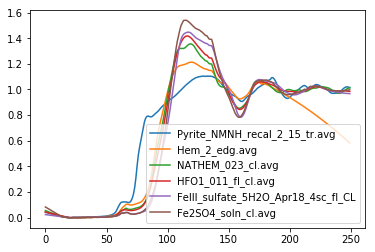

In [122]:
df = create_df_from_nor(athenafile = 'fe_refs.nor')

for_corr_df = df.drop('energy',1)
#plt.imshow(for_corr_df.corr(method = 'kendall'), cmap = 'Reds')
for_corr_df.plot()
#for_corr_df.corr(method = 'kendall')

# Rolling Window Correlation

In [ ]:
# Set window size to compute moving window synchrony.
r_window_size = 120
# Interpolate missing data.
df_interpolated = df.interpolate()
# Compute rolling window synchrony
rolling_r = df_interpolated['S1_Joy'].rolling(window=r_window_size, center=True).corr(df_interpolated['S2_Joy'])
f,ax=plt.subplots(2,1,figsize=(14,6),sharex=True)
df.rolling(window=30,center=True).median().plot(ax=ax[0])
ax[0].set(xlabel='Frame',ylabel='Smiling Evidence')
rolling_r.plot(ax=ax[1])
ax[1].set(xlabel='Frame',ylabel='Pearson r')
plt.suptitle("Smiling data and rolling window correlation")

# Dynamic Time Wrapping

Reference: http://alumni.cs.ucr.edu/~xxi/495.pdf



In [98]:
from dtw import dtw,accelerated_dtw
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean, cityblock, cosine

In [112]:
d1 = df['Pyrite_NMNH_recal_2_15_tr.avg'].interpolate().values
d2 = df['HFO1_011_fl_cl.avg'].interpolate().values
d, cost_matrix, acc_cost_matrix, path = accelerated_dtw(d1,d2, dist='euclidean')
d

10.238984891787979

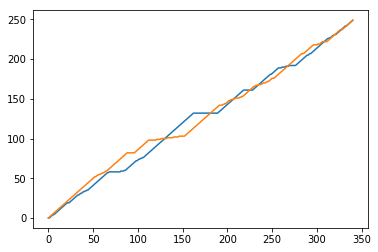

In [124]:
x = df.iloc[:,1]
y = df.iloc[:,4]

#d, cost_matrix, acc_cost_matrix, path = accelerated_dtw([1,2,3],[3,4,5], dist='euclidean')

distance, path = fastdtw(d1, d2, dist = euclidean)

plt.plot(path)

In [118]:
from scipy.spatial import distance

for ii in range(len(df.T)):
    ref =  df.iloc[:,1]
    if ii>0:
        data = df.iloc[:,ii]
        dist, path = fastdtw(ref, data, dist = euclidean)
        print(dist)

0.0
15.075252860873997
8.276073617770802
10.239012148237979
12.356736447142994
15.463551487340993
